# DonorsChoose.org Application Screening

## Read in data

In [36]:
DEBUG = False
TRAIN = True
%matplotlib inline

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks')

pd.options.display.max_columns = 200

In [37]:
# Set up directories
data_dir = 'data'
output_dir = 'output'
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)

# Read in all available data
res = pd.read_csv(os.path.join(data_dir, 'resources.csv'), dtype='str')
train = pd.read_csv(os.path.join(data_dir, 'train.csv'), parse_dates=[4], dtype='str')
test = pd.read_csv(os.path.join(data_dir, 'test.csv'), parse_dates=[4], dtype='str')

## Comb through each feature

#### resources.csv

In [38]:
res.head(5)

,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95
2,p069063,Cory Stories: A Kid's Book About Living With Adhd,1,8.45
3,p069063,"Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...",2,13.59
4,p069063,EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...,3,24.95


In [39]:
# Convert numeric values to float
res['quantity'] = pd.to_numeric(res['quantity'], errors='coerce')
res['price'] = pd.to_numeric(res['price'], errors='coerce')

In [40]:
res.describe(include='all')

,id,description,quantity,price
count,1541272,1540980,1.541272e+06,1.541272e+06
unique,260115,332928,NaN,NaN
top,p066966,Apple - iPad� mini 2 with Wi-Fi - 16GB - Space...,NaN,NaN
freq,100,3037,NaN,NaN
mean,NaN,NaN,2.860509e+00,5.028398e+01
std,NaN,NaN,7.570345e+00,1.447326e+02
min,NaN,NaN,1.000000e+00,0.000000e+00
25%,NaN,NaN,1.000000e+00,7.900000e+00
50%,NaN,NaN,1.000000e+00,1.499000e+01
75%,NaN,NaN,2.000000e+00,3.980000e+01


Each proposal has a list of items requested. Each proposal may request multiple item types, and multiples of any given item. The quantity requested and price of each item is given. We will want to map the requests to a single proposal, so some summarizing will be necessary. There are many features possible here, it makes sense to anchor the desired features to answerable questions.

- **Do cheap or expensive proposals tend to get approved?**
    - Highest/Lowest price of items (max/min of `price`)
    - Total cost of request (sum of `price` * `quantity` for each proposal)
- **Do proposals with few or many items tend to get approved?**
    - Total number of items requested (sum of `quantity`)
    - Total number of unique items requested (count of items per proposal)
- **Does the type of item requested affect approval?**
    - Aggregation of all words from item descriptions (string join of `description`)

The possibility of information being gleaned from the list of descriptions means that text analysis will need to be used. This was obvious from the data descriptions but here it becomes apparent. 

#### train.csv

In [41]:
train.head(5)

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,p036502,484aaf11257089a66cfedc9461c6bd0a,Ms.,NV,2016-11-18 14:45:59,Grades PreK-2,Literacy & Language,Literacy,Super Sight Word Centers,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...,NaN,NaN,My students need 6 Ipod Nano's to create and d...,26,1
1,p039565,df72a3ba8089423fa8a94be88060f6ed,Mrs.,GA,2017-04-26 15:57:28,Grades 3-5,"Music & The Arts, Health & Sports","Performing Arts, Team Sports",Keep Calm and Dance On,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,NaN,NaN,My students need matching shirts to wear for d...,1,0
2,p233823,a9b876a9252e08a55e3d894150f75ba3,Ms.,UT,2017-01-01 22:57:44,Grades 3-5,"Math & Science, Literacy & Language","Applied Sciences, Literature & Writing",Lets 3Doodle to Learn,Hello;\r\nMy name is Mrs. Brotherton. I teach ...,We are looking to add some 3Doodler to our cla...,NaN,NaN,My students need the 3doodler. We are an SEM s...,5,1
3,p185307,525fdbb6ec7f538a48beebaa0a51b24f,Mr.,NC,2016-08-12 15:42:11,Grades 3-5,Health & Sports,Health & Wellness,"\""Kid Inspired\"" Equipment to Increase Activit...",My students are the greatest students but are ...,"The student's project which is totally \""kid-i...",NaN,NaN,My students need balls and other activity equi...,16,0
4,p013780,a63b5547a7239eae4c1872670848e61a,Mr.,CA,2016-08-06 09:09:11,Grades 6-8,Health & Sports,Health & Wellness,We need clean water for our culinary arts class!,My students are athletes and students who are ...,For some reason in our kitchen the water comes...,NaN,NaN,My students need a water filtration system for...,42,1


In [42]:
# Convert numeric values to float
train['teacher_number_of_previously_posted_projects'] = pd.to_numeric(train['teacher_number_of_previously_posted_projects'], errors='coerce')

In [43]:
train.describe(include='all')

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
count,182080,182080,182076,182080,182080,182080,182080,182080,182080,182080,182080,6374,6374,182080,182080.000000,182080
unique,182080,104414,5,51,180439,4,51,407,164282,147689,180984,6359,6336,179730,NaN,2
top,p230064,fa2f220b537e8653fb48878ebb38044d,Mrs.,CA,2016-09-01 00:00:03,Grades PreK-2,Literacy & Language,Literacy,Flexible Seating,As a teacher in a low-income/high poverty scho...,Students will be using Chromebooks to increase...,"Daily, students will check out their chrome bo...","Having taught engineering in college, I have c...",My students need electronic tablets to do all ...,NaN,1
freq,1,74,95405,25695,30,73890,39257,15775,377,46,24,2,3,84,NaN,154346
first,NaN,NaN,NaN,NaN,2016-04-27 00:03:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,2017-04-30 23:50:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.237055,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.016086,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN


In [44]:
if DEBUG:
    train = train.loc[:100,:]
train.shape

(182080, 16)

Notes on first pass of features

- `id` - unique id of the project application
    - Used to tie `resources.csv` data in
- `teacher_id` - id of the teacher submitting the application
    - Counts of submissions per teacher captured in other feature, `teacher_number_of_previously_posted_projects`
    - Will be disregarded
- `teacher_prefix` - title of the teacher's name (Ms., Mr., etc.)
    - Categorical data with few unique values, likely useful
    - Needs to be encoded
- `school_state` - US state of the teacher's school
    - Categorical data with ~50 unique values, likely useful
    - Needs to be encoded
- `project_submitted_datetime` - application submission timestamp
    - Needs to be split into multiple columns
        - Year
        - Month
        - Day of year
        - Day of week
        - Hour of day
- `project_grade_category` - school grade levels (PreK-2, 3-5, 6-8, and 9-12)
    - Categorical data with few unique values, likely useful
    - Needs to be encoded
- `project_subject_categories` - category of the project (e.g., "Music & The Arts")
    - Categorical data with few unique values, likely useful
    - Several records have 2 entries, needs to be split into 2 new columns
    - Needs to be encoded
- `project_subject_subcategories` - sub-category of the project (e.g., "Visual Arts")
    - Categorical data with few unique values, likely useful
    - Several records have 2 entries, needs to be split into 2 new columns
    - Needs to be encoded
- `project_title` - title of the project
    - Needs to be normalized
- `project_essay_1` - `project_essay_4`
    - Essays will need to be combined, see section XYZ #FIXME
- `project_resource_summary` - summary of the resources needed for the project
    - Needs to be augmented with `resources.csv` data
- `teacher_number_of_previously_posted_projects` - number of previously posted applications by the submitting teacher
    - Useful as is
- `project_is_approved` - whether DonorsChoose proposal was accepted (0="rejected", 1="accepted"); train.csv only
    - Class labels

Note: Prior to May 17, 2016, the prompts for the essays were as follows:

- `project_essay_1`: "Introduce us to your classroom"
- `project_essay_2`: "Tell us more about your students"
- `project_essay_3`: "Describe how your students will use the materials you're requesting"
- `project_essay_4`: "Close by sharing why your project will make a difference"

The target variable is contained in `project_is_approved`, with binary classes: rejected=0 and approved=1. 

Looking at the training data it becomes apparent that two approaches should be used to solve this classification problem:

1. **Classification based on categorical features**
1. **Classification based on text information**

The questions and corresponding features that come to mind are:

- **Do the categorical features independently have an affect on approval?**
    - `['teacher_prefix', 'school_state', 'project_grade_category', 'project_subject_categories', 'project_subject_subcategories']`
    - Acceptance rate of each feature
    - Number of submissions of each feature
- **Does the date of submission affect approval?**
    - Approval rates by year, month, day of year, day of week, hour of day
- **Do new or experienced submitters get approved more?**
    - Acceptance rate of `teacher_number_of_previously_posted_projects`
- **Does the title affect approval?**
    - Number of words in `project_title`
    - Sentiment of `project_title`
- **The big one: Do the essays affect approval?**
    - Length of each essay
        - Number of characters
        - Number of words
        - Word density
    - After cleaning essay text* evaluate the following:
        - SVM linear classification
        - Topic models of each essay
        - doc2vec models of each essay
- **Does the resource summary affect approval?**
    - Closely linked with aggregated description field from resources table
    
*Cleaning text covered in section XYZ #FIXME

Essays are an interesting chunk of this dataset and potentially have a wealth of information in them. Every application has questions 1 and 2, but the counts of questions 3 and 4 are significantly lower. Typically if there are large amounts of missing data in an attribute, it would be thrown out. However, I believe that removing `project_essay_3` and `project_essay_4` from consideration would throw away useful data. According to the data description: 
>Note: Prior to May 17, 2016, the prompts for the essays were as follows:
- `project_essay_1`: "Introduce us to your classroom"
- `project_essay_2`: "Tell us more about your students"
- `project_essay_3`: "Describe how your students will use the materials you're requesting"
- `project_essay_4`: "Close by sharing why your project will make a difference"

>Starting on May 17, 2016, the number of essays was reduced from 4 to 2, and the prompts for the first 2 essays were changed to the following:
- `project_essay_1`: "Describe your students: What makes your students special? Specific details about their background, your neighborhood, and your school are all helpful."
- `project_essay_2`: "About your project: How will these materials make a difference in your students' learning and improve their school lives?"

To me, the newer question 1 appears to be a combination of the old questions 1 and 2, while the newer question 2 appears to be a combination of the old questions 3 and 4. The old questions 1 and 2 ask about the classroom and students, while the new question 2 asks about the students and the school. The old questions 3 and 4 ask about how materials will be used and how they will make a difference, while the new question 2 addresses the same topics.

As such I will combine the old question 1 and 2 into question 1, and the old question 3 and 4 into quesiton 2.

#### test.csv

In [45]:
test.head(5)

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects
0,p233245,5724a0c3ce11008366fff36dab4b943c,Ms.,CA,2016-04-27 13:45:41,Grades PreK-2,Music & The Arts,Visual Arts,Art Will Make You Happy!,My 2nd grade students are amazing! They are v...,My class is made up of 12 boys and 12 girls. ...,My second grade class will really benefit from...,The genorous donations to my project will make...,My students need a drying rack for their art p...,2
1,p096795,445619941dc7cbe81c7be109dc61a56a,Mrs.,SC,2016-04-28 12:43:56,Grades 3-5,"Literacy & Language, Math & Science","Literature & Writing, Mathematics",Keeping up with the TIMEs,Students within the classroom work in small gr...,My students are all very talented young indivi...,"We do a lot of small group, where the student ...",This project is very important to my classroom...,My students need Time Magazines for next year ...,1
2,p236235,e92a4902b1611a189643d6f12c51e6a0,Mrs.,SC,2016-04-29 21:16:05,Grades PreK-2,Math & Science,"Applied Sciences, Mathematics",Building Bridges to Problem Solving,My students share a love of learning. These s...,My class consists of 14 energetic learners. O...,These Fairy Tale Problem Solving STEM kits wil...,These materials will be help my students with ...,My students need to be mentally stimulated to ...,0
3,p233680,8e92622d2985d3faac1de71609c4be72,Mrs.,IA,2016-04-27 22:32:43,Grades PreK-2,Literacy & Language,Literacy,Classroom Library,Reading is the gateway to the soul. Guiding c...,First graders enter the classroom each day rea...,Book bins will help to organize our classroom ...,"When students begin the first grade, many are ...",My students need an organized classroom library.,0
4,p171879,91a3c89981f626d9a0d067c65fb186ce,Mr.,CA,2016-04-27 18:59:15,Grades 6-8,"Music & The Arts, Special Needs","Performing Arts, Special Needs",Reeds so we can Read,"\""Mr. Reyes! I need another reed!\"" I hear t...",We have a diverse population with almost entir...,Each day in my class students consume supplies...,My students come from very troubled homes and ...,My students need reeds to perform in class eac...,1


In [46]:
# Convert numeric values to float
test['teacher_number_of_previously_posted_projects'] = pd.to_numeric(test['teacher_number_of_previously_posted_projects'], errors='coerce')

In [47]:
test.describe(include='all')

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects
count,78035,78035,78034,78035,78035,78035,78035,78035,78035,78035,78035,2704,2704,78035,78035.000000
unique,78035,55508,5,51,77646,4,51,390,72755,69435,77826,2702,2692,77531,NaN
top,p240968,df8a4b7ad173b57f7ac52e447cc24043,Mrs.,CA,2016-09-01 00:00:06,Grades PreK-2,Literacy & Language,Literacy,Flexible Seating,I teach a special day class that is filled wit...,Students will be using Chromebooks to increase...,These materials would will protect the eyes of...,"Currently, there is a huge problem with inner-...",My students need electronic tablets to do all ...,NaN
freq,1,37,40982,10723,8,31471,16777,6859,167,23,11,2,3,32,NaN
first,NaN,NaN,NaN,NaN,2016-04-27 00:06:07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,2017-04-30 23:37:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.275082
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.981717
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000


Confirmed that the test data is of the same form as the training data, minus the class labels.

In [48]:
df = train
if not TRAIN:
    df = test

## Feature engineering

#### Resources table summarized and combined with train table

In [49]:
# Calculate the total cost of each item
res['cost'] = res['quantity'] * res['price']
# Calculate the total cost of each proposal
res_unique = res.groupby(by='id').agg({'description': 'count',
                                       'quantity': 'sum',
                                       'price': 'median',
                                       'cost': 'sum'})
res_unique.columns = ['res_count', 'res_quantity', 'res_median_price', 'res_total_cost']

res['description'].fillna('', inplace=True)
res_unique['res_descriptions'] = res.groupby(by='id')['description'].apply(', '.join)

res_unique.head()

,res_count,res_quantity,res_median_price,res_total_cost,res_descriptions
id,,,,,
p000001,4,7,87.245,833.63,"Cap Barbell 300 Pound Olympic Set, Grey, Cap B..."
p000002,14,21,29.990,630.28,"10 Sony Headphones (BUY 9 GET 1 FREE), Belkin ..."
p000003,4,4,44.990,298.97,EE820X - Phonemic Awareness Instant Learning C...
p000004,95,98,7.260,1126.22,A Bad Case of the Giggles Poems That Will Make...
p000005,4,8,54.080,702.31,"Fitbit Zip Wireless Activity Tracker, Lime, Fi..."


In [50]:
df = pd.merge(df, res_unique[~res_unique.index.duplicated(keep='first')], how='left', on='id')

#### Training data split out

In [51]:
# Split up subject categories into individual columns
df['subject_a'], df['subject_b'] = df['project_subject_categories'].str.split(',', 1).str
df['subject_c'], df['subject_d'] = df['project_subject_subcategories'].str.split(',', 1).str

# Split up datetime into columns
df['date_year'] = df['project_submitted_datetime'].dt.year
df['date_month'] = df['project_submitted_datetime'].dt.month
df['date_dow'] = df['project_submitted_datetime'].dt.dayofweek
df['date_doy'] = df['project_submitted_datetime'].dt.dayofyear
df['date_hour'] = df['project_submitted_datetime'].dt.hour

In [52]:
# Combine subject categories into single feature
cols = ['subject_a', 'subject_b', 'subject_c', 'subject_d']
# Remove escaped characters from text
for c in cols:
    df[c].fillna('', inplace=True)
df['subject_agg'] = df[cols].apply(' '.join, axis=1)

In [53]:
# Combine essays and project title into single feature
cols = ['project_title', 'project_essay_1', 'project_essay_2', 'project_essay_3', 'project_essay_4']
# Remove escaped characters from text
for c in cols:
    df[c].fillna('', inplace=True)
    df[c] = df[c].apply(lambda s: s.replace('\\"', ' '))
    df[c] = df[c].apply(lambda s: s.replace('\\r', ' '))
    df[c] = df[c].apply(lambda s: s.replace('\\n', ' '))
    df[c] = df[c].apply(lambda s: s.strip())

df['essay_agg'] = df[['project_title', 'project_essay_1', 'project_essay_2', 'project_essay_3', 'project_essay_4']].apply(' '.join, axis=1)

cols = ['essay_agg', 'project_title', 'project_essay_1', 'project_essay_2', 'project_essay_3', 'project_essay_4']
for c in cols:    
    # Get word counts for each essay, etc.
    df['word_count_' + c] = df[c].apply(lambda s: len(s.split()))

In [54]:
df.rename({'teacher_number_of_previously_posted_projects': 'num_previous'}, inplace=True, axis='columns')

In [55]:
df.set_index('id', inplace=True)

In [56]:
# Split out categorical features, text, and labels
text = df[['project_title',
           'project_essay_1',
           'project_essay_2',
           'project_essay_3',
           'project_essay_4',
           'project_resource_summary',
           'essay_agg',
           'subject_agg',
           'res_descriptions'
         ]]
categorical = df[['teacher_prefix',
                  'school_state',
                  'project_grade_category',
                  'subject_a',
                  'subject_b',
                  'subject_c',
                  'subject_d'
                ]]
remaining = df[['res_count', 
                'res_quantity',
                'res_median_price',
                'res_total_cost',
                'word_count_essay_agg', 
                'word_count_project_title', 
                'word_count_project_essay_1', 
                'word_count_project_essay_2', 
                'word_count_project_essay_3', 
                'word_count_project_essay_4',
                'num_previous'
              ]]
if TRAIN:
    labels = df[['project_is_approved']].astype('int')

In [57]:
encoded = categorical.apply(lambda s: s.astype('category').cat.codes)
cat_one_hot = pd.get_dummies(categorical, drop_first=True)
# Data to use for training/evaluating models
df_model = pd.merge(cat_one_hot, remaining[~remaining.index.duplicated(keep='first')], how='left', left_index=True, right_index=True)

In [58]:
# Data to use for visualizations and exploration
df_corr = pd.merge(encoded, remaining[~remaining.index.duplicated(keep='first')], how='left', left_index=True, right_index=True)
df_corr = pd.merge(df_corr, labels[~remaining.index.duplicated(keep='first')], how='left', left_index=True, right_index=True)

## Finding correlations or relationships

In [59]:
corr = df_corr.corr()
corr

,teacher_prefix,school_state,project_grade_category,subject_a,subject_b,subject_c,subject_d,res_count,res_quantity,res_median_price,res_total_cost,word_count_essay_agg,word_count_project_title,word_count_project_essay_1,word_count_project_essay_2,word_count_project_essay_3,word_count_project_essay_4,num_previous,project_is_approved
teacher_prefix,1.000000,0.004967,0.048296,0.006946,0.041221,0.027082,0.009711,0.057569,0.025532,-0.045093,-0.039278,0.016086,-0.011570,0.026605,0.007970,-0.007432,-0.008063,-0.022445,-0.014121
school_state,0.004967,1.000000,0.007119,-0.002058,0.004125,0.020511,-0.009029,0.011132,-0.002747,-0.013583,-0.024685,-0.022806,-0.012772,-0.015848,-0.019228,-0.000379,0.000943,-0.023936,-0.001494
project_grade_category,0.048296,0.007119,1.000000,-0.072856,0.045491,0.010758,-0.002285,0.023686,-0.068087,-0.008215,-0.043451,-0.029820,-0.008907,-0.033660,-0.012846,-0.004661,-0.005104,0.030610,-0.008110
subject_a,0.006946,-0.002058,-0.072856,1.000000,-0.165586,0.326184,-0.187185,-0.001531,0.011367,0.032936,-0.001620,-0.057815,-0.019016,-0.000578,-0.075450,-0.004451,-0.003902,0.001347,0.001697
subject_b,0.041221,0.004125,0.045491,-0.165586,1.000000,-0.017582,0.709182,-0.041944,-0.055600,0.025611,0.016071,0.035759,0.021596,0.012767,0.024063,0.024298,0.021577,0.008656,0.007832
subject_c,0.027082,0.020511,0.010758,0.326184,-0.017582,1.000000,-0.237170,0.025062,0.045104,-0.039458,-0.047900,-0.046955,-0.030957,-0.013766,-0.043508,-0.015061,-0.015023,-0.013872,0.019026
subject_d,0.009711,-0.009029,-0.002285,-0.187185,0.709182,-0.237170,1.000000,-0.015343,-0.033651,0.030936,0.035661,0.073577,0.045254,0.023773,0.060136,0.034479,0.033057,0.024066,-0.000289
res_count,0.057569,0.011132,0.023686,-0.001531,-0.041944,0.025062,-0.015343,1.000000,0.404960,-0.189118,0.031921,0.066273,0.036276,0.027915,0.066783,0.004523,0.001710,0.033318,-0.109516
res_quantity,0.025532,-0.002747,-0.068087,0.011367,-0.055600,0.045104,-0.033651,0.404960,1.000000,-0.193363,0.138094,0.045877,0.031013,0.027640,0.033093,0.013594,0.012306,0.006949,-0.053147
res_median_price,-0.045093,-0.013583,-0.008215,0.032936,0.025611,-0.039458,0.030936,-0.189118,-0.193363,1.000000,0.458196,0.002361,0.010645,0.004536,-0.001830,0.002096,0.001916,-0.010514,0.052195


In [60]:
kinda_corr = list(corr.loc[(corr['project_is_approved'] < -0.1) | (corr['project_is_approved'] > 0.1) & (corr['project_is_approved'] < 1)].index)
kinda_corr

['res_count']

[Text(0,0,'teacher_prefix'),
 Text(0,0,'school_state'),
 Text(0,0,'project_grade_category'),
 Text(0,0,'subject_a'),
 Text(0,0,'subject_b'),
 Text(0,0,'subject_c'),
 Text(0,0,'subject_d'),
 Text(0,0,'res_count'),
 Text(0,0,'res_quantity'),
 Text(0,0,'res_median_price'),
 Text(0,0,'res_total_cost'),
 Text(0,0,'word_count_essay_agg'),
 Text(0,0,'word_count_project_title'),
 Text(0,0,'word_count_project_essay_1'),
 Text(0,0,'word_count_project_essay_2'),
 Text(0,0,'word_count_project_essay_3'),
 Text(0,0,'word_count_project_essay_4'),
 Text(0,0,'num_previous'),
 Text(0,0,'project_is_approved')]

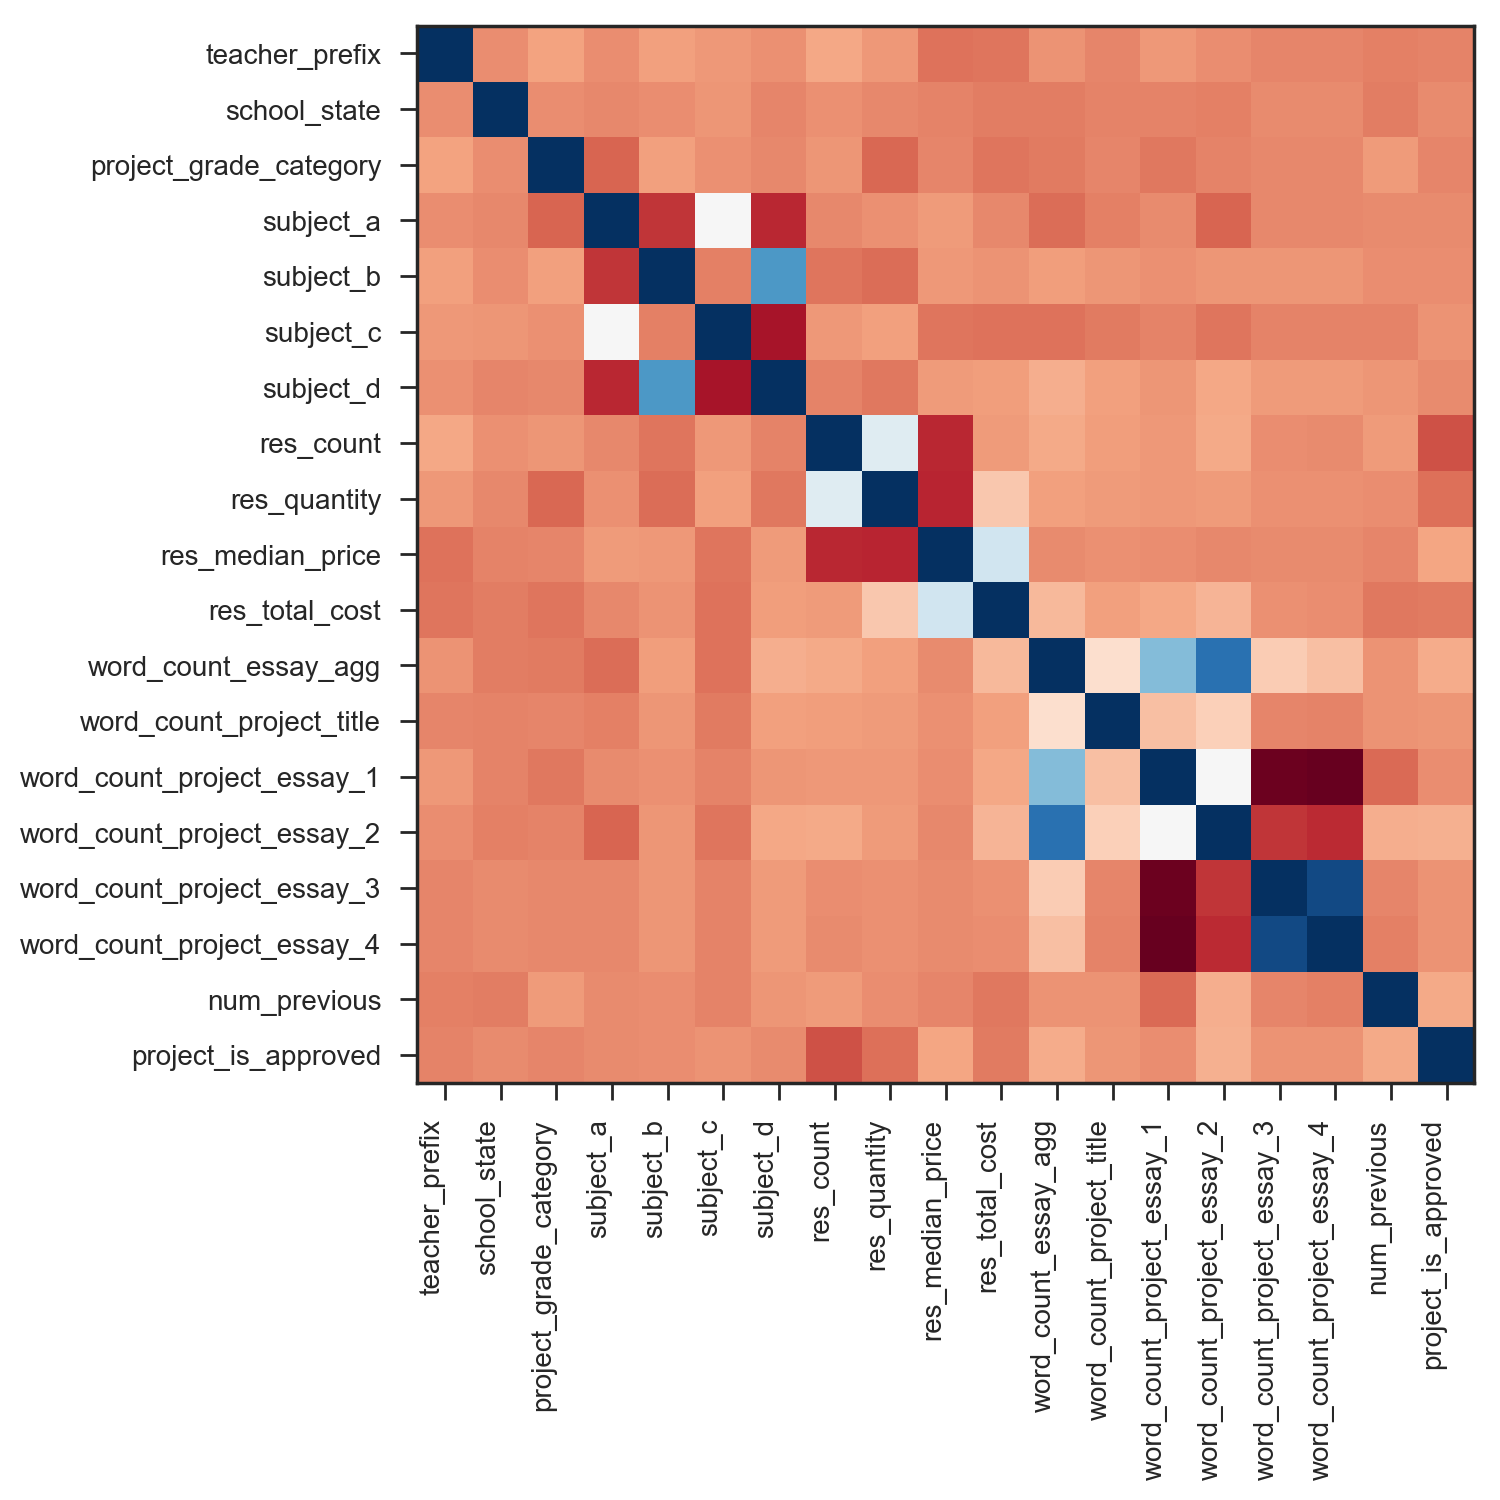

In [64]:
fig, ax = plt.subplots(figsize=(7,7), dpi=200)
plt.imshow(corr, interpolation='nearest', cmap='RdBu')
ticks = list(range(len(corr.columns)))
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ticklabels = list(corr.columns)
ax.set_xticklabels(ticklabels, rotation=90, ha="right")
ax.set_yticklabels(ticklabels)

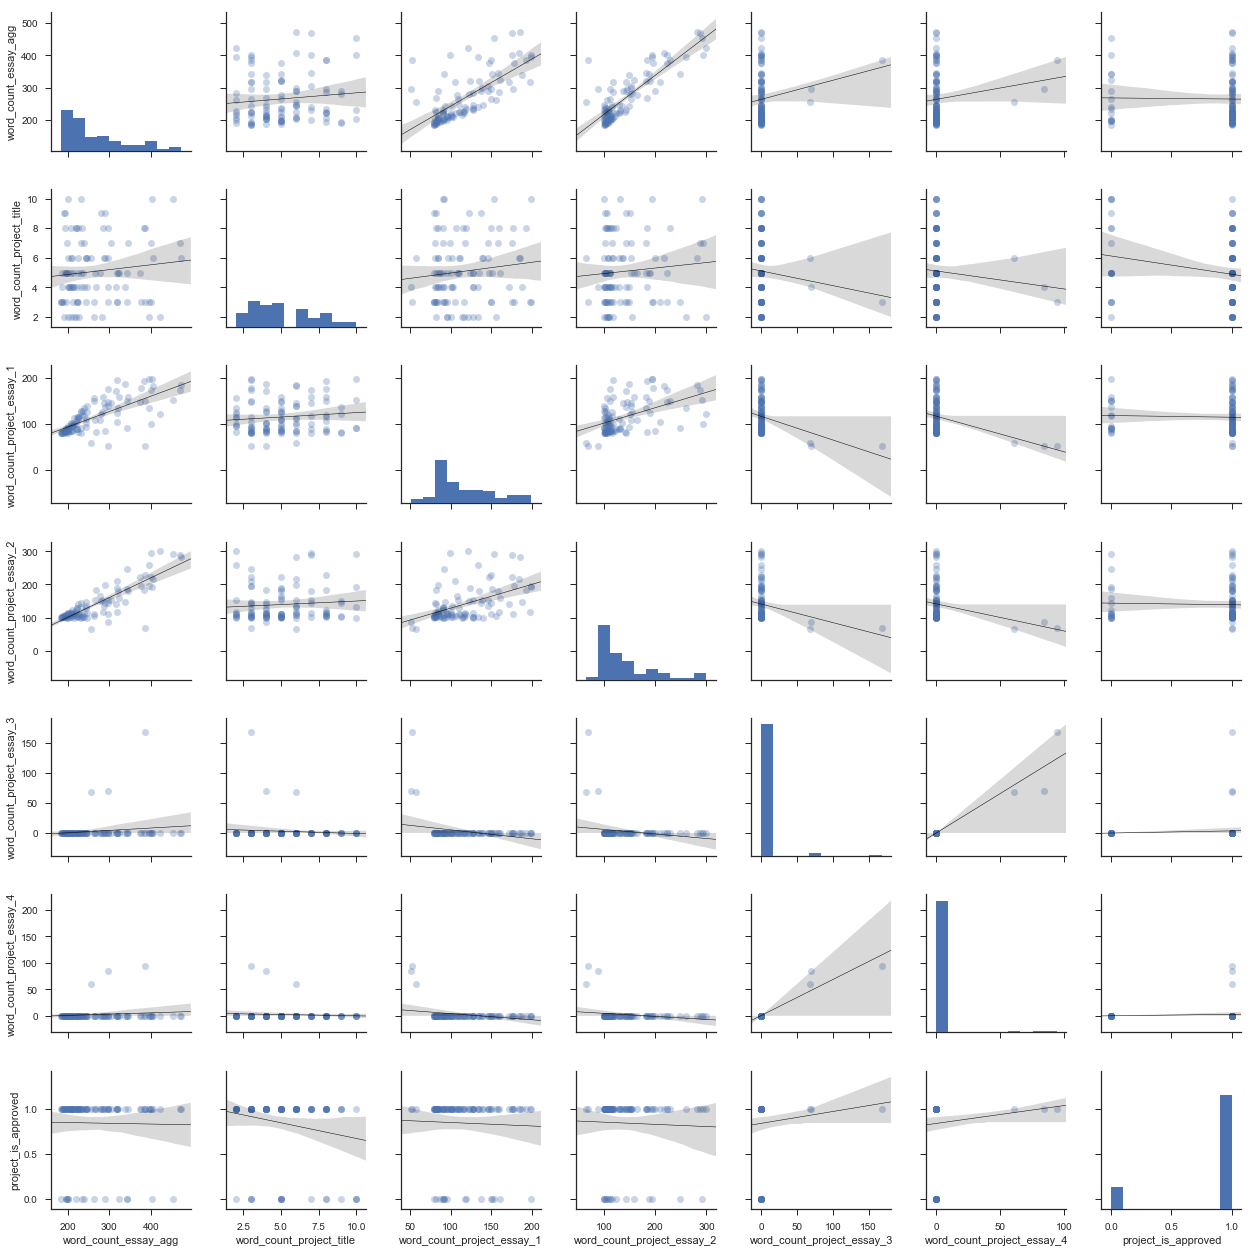

In [28]:
cols = ['word_count_essay_agg',
        'word_count_project_title',
        'word_count_project_essay_1',
        'word_count_project_essay_2',
        'word_count_project_essay_3',
        'word_count_project_essay_4',
        'project_is_approved'
       ]
plot_kws = {'line_kws': {'color': 'black', 'lw':0.5}, 
            'scatter_kws': {'alpha': 0.3}}
sns.pairplot(df_corr[cols], 
             kind='reg',
             plot_kws=plot_kws)

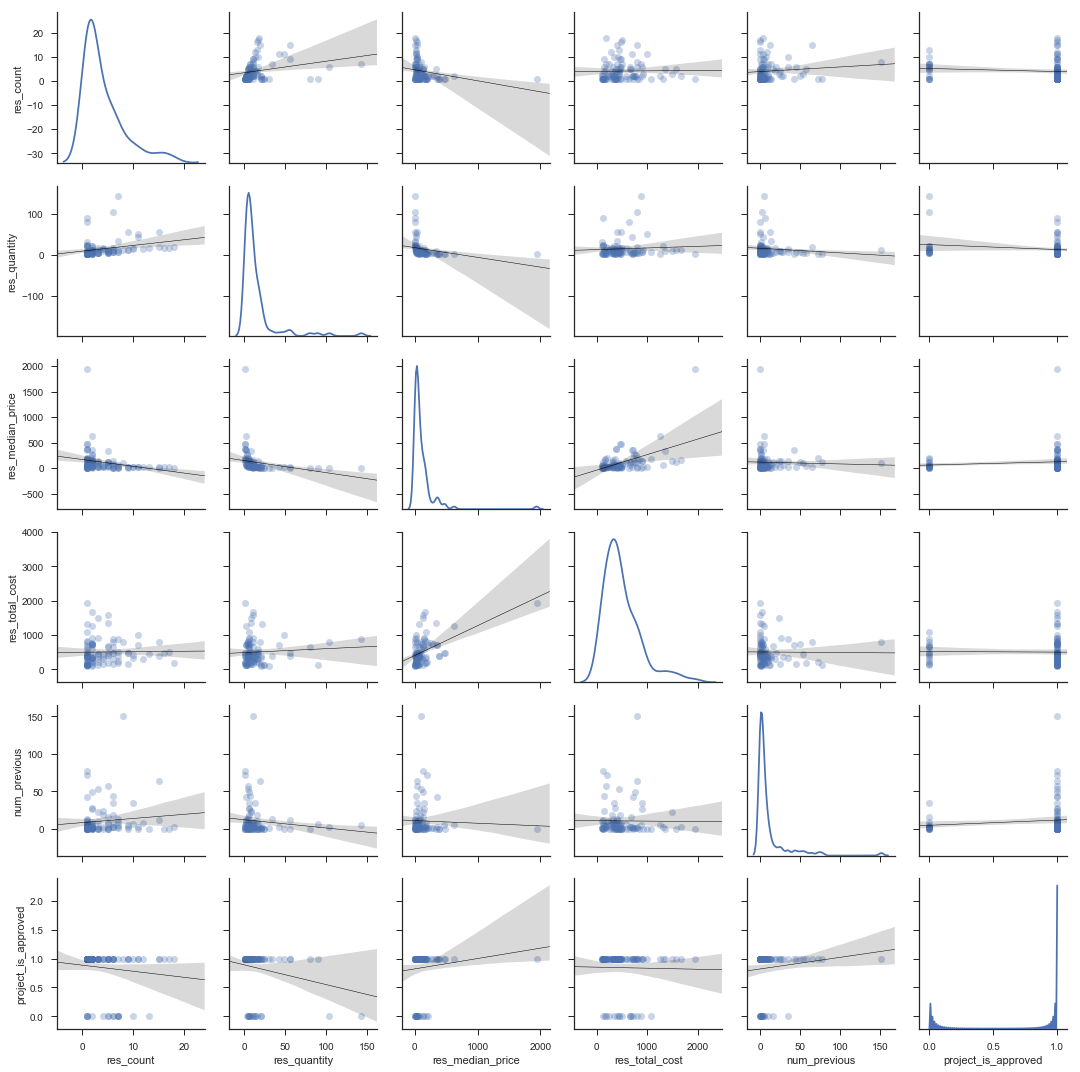

In [29]:
cols = ['res_count',
        'res_quantity',
        'res_median_price',
        'res_total_cost',
        'num_previous',
        'project_is_approved'
       ]
plot_kws = {'line_kws': {'color': 'black', 'lw':0.5}, 
            'scatter_kws': {'alpha': 0.3}}
sns.pairplot(df_corr[cols], 
             kind='reg', 
             diag_kind='kde',
             plot_kws=plot_kws)

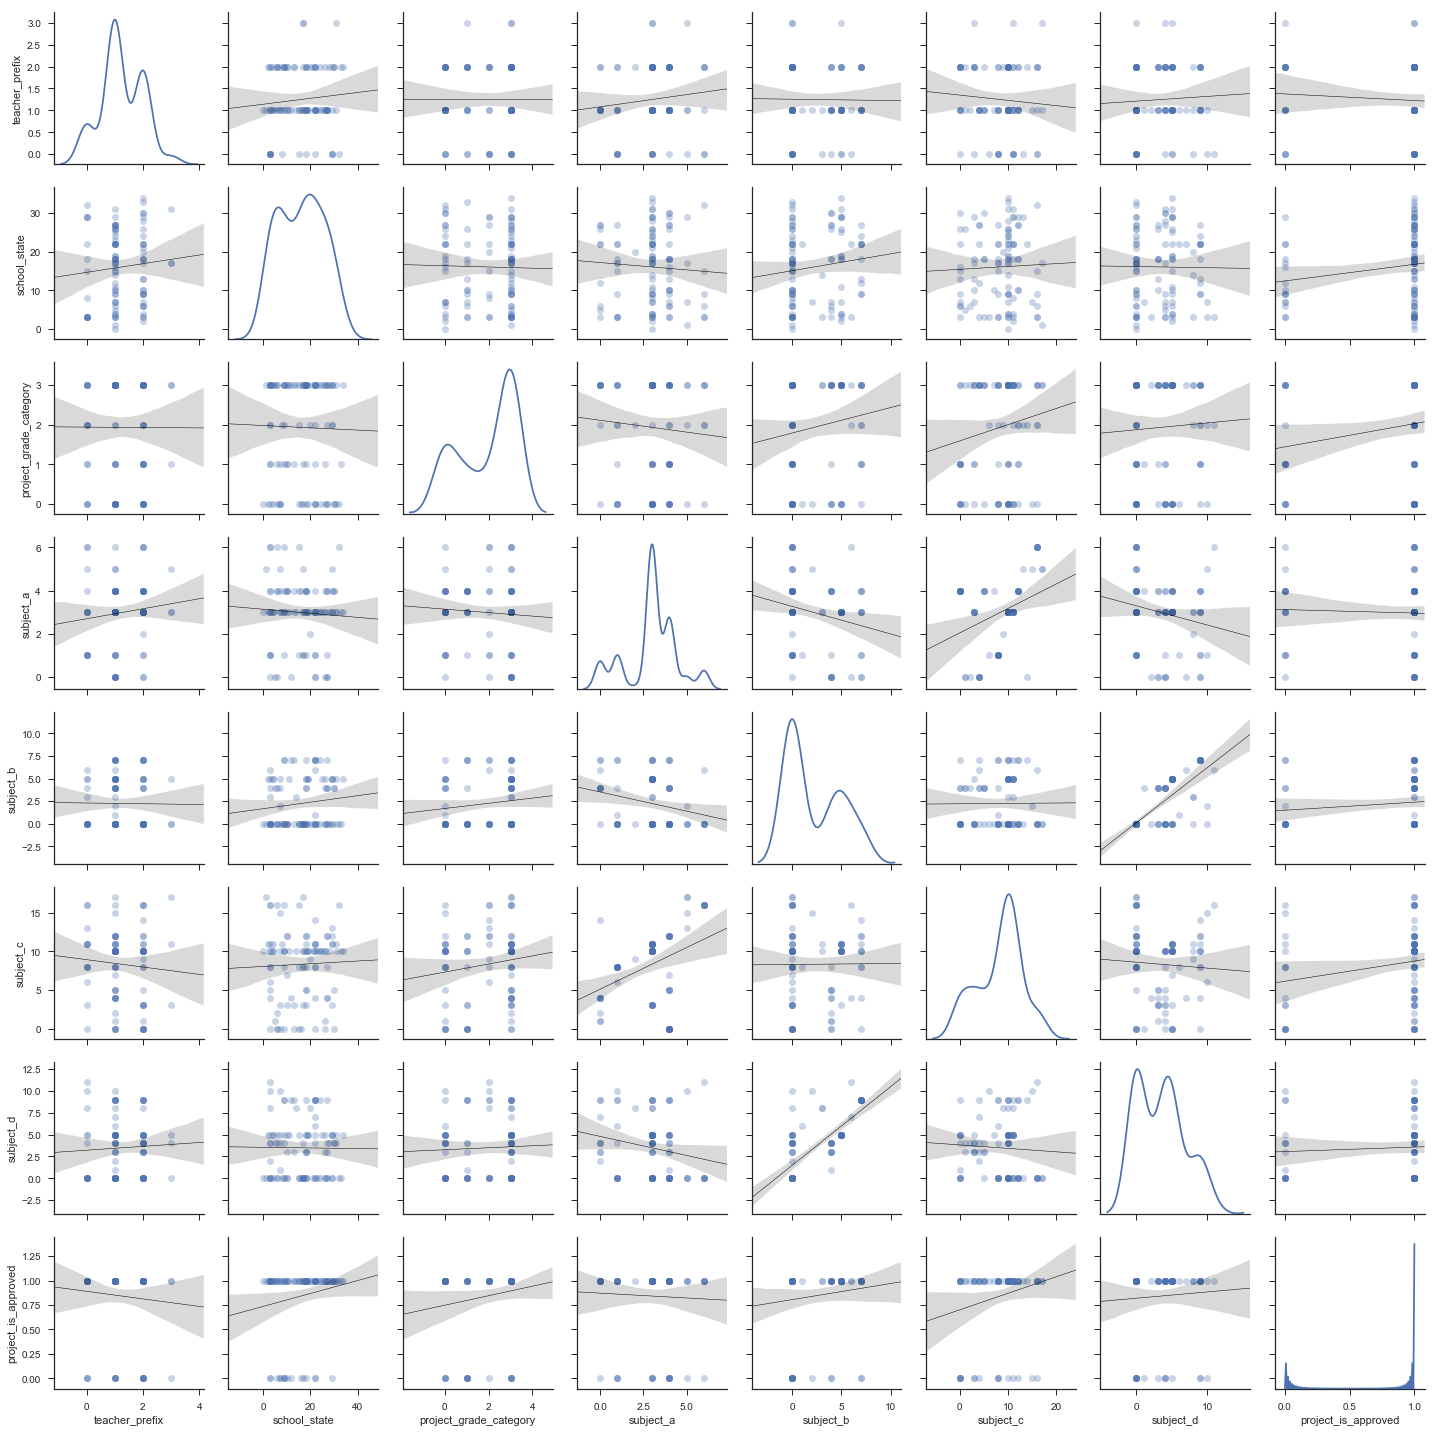

In [30]:
cols = ['teacher_prefix',
        'school_state',
        'project_grade_category',
        'subject_a',
        'subject_b',
        'subject_c',
        'subject_d',
        'project_is_approved'
       ]
plot_kws = {'line_kws': {'color': 'black', 'lw':0.5}, 
            'scatter_kws': {'alpha': 0.3}}
sns.pairplot(df_corr[cols], 
             kind='reg', 
             diag_kind='kde',
             plot_kws=plot_kws)

## Categorical prediction (cross validation testing)

In [61]:
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

names = [#'Nearest Neighbors',
         #'Gaussian Process',
         'Decision Tree',
         'Random Forest',
         'Neural Net',
         #'Naive Bayes'
        ]
classifiers = [#KNeighborsClassifier(3),
               #GaussianProcessClassifier(1.0 * RBF(1.0)),
               DecisionTreeClassifier(max_depth=5),
               RandomForestClassifier(max_depth=5, n_estimators=10),
               MLPClassifier(alpha=1),
               #GaussianNB()
              ]

In [72]:
list(corr[corr['project_is_approved'].abs()>=0.05].index)

['res_count',
 'res_quantity',
 'res_median_price',
 'word_count_essay_agg',
 'word_count_project_essay_2',
 'num_previous',
 'project_is_approved']

In [75]:
#cat_corr = categorical[['school_state',
#                        'project_grade_category',
#                        'subject_b']]
#cat_one_hot = pd.get_dummies(cat_corr, drop_first=True)
rem_corr = remaining[['res_count',
                      'res_quantity',
                      'res_median_price',
                      'word_count_essay_agg',
                      'word_count_project_essay_2',
                      'num_previous']]
# Data to use for training/evaluating models
#df_model_corr = pd.merge(cat_one_hot, rem_corr[~rem_corr.index.duplicated(keep='first')], how='left', left_index=True, right_index=True)
df_model_corr = rem_corr.copy()

In [76]:
labels_series = labels['project_is_approved']

In [77]:
kfold = model_selection.KFold(n_splits=5, random_state=1138)

for name, clf in zip(names, classifiers):
    out = model_selection.cross_val_score(clf, df_model, labels_series, cv=kfold)
    print('{} ACC: {:0.3f}%  STD: {:0.3f}%'.format(name, out.mean()*100.0, out.std()*100.0))

Decision Tree ACC: 84.766%  STD: 0.129%
Random Forest ACC: 84.768%  STD: 0.131%
Neural Net ACC: 84.383%  STD: 0.456%


## NLP Prediction (cross validation testing)

In [396]:
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

In [397]:
stop_words = stopwords.words('english') + list(string.punctuation)
stm = PorterStemmer()
def normalize_text(s):
    tokens = [stm.stem(t.lower()) for t in word_tokenize(s) if t not in stop_words]
    normalized = ' '.join(tokens)
    return normalized
    
text['essay_norm'] = text['essay_agg'].apply(normalize_text)

/Users/aaronpenne/miniconda3/envs/dc/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [398]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

## Predict output with test data #FIXME Functionalize everything so it can be done on train and test

####  Fancy embedding approach with sentence2vec

https://www.kaggle.com/shivamb/extensive-text-data-feature-engineering/notebook
http://www.developintelligence.com/blog/2017/06/practical-neural-networks-keras-classifying-yelp-reviews/
https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

In [402]:
xtrain = text['essay_norm'].values

In [405]:
# https://fasttext.cc/docs/en/english-vectors.html
import io

def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = map(float, tokens[1:])
    return data

#f = open(EMBEDDING_FILE)
#for line in f:
#    if run_for_small_data and len(embeddings_index) == 100:
#      break
#    values = line.split()
#    word = values[0]
#    coefs = np.asarray(values[1:], dtype='float32')
#    embeddings_index[word] = coefs
#f.close()

In [403]:
from nltk import word_tokenize
# FIXME file name
embedding_vector_pretrained = load_vectors('FILENAMEHERE')

def sent2vec(sent):
    matrix = []
    tokens = word_tokenize(sent)
    for word in tokens:
        if word in embedding_vector_pretrained:
            matrix.append(embedding_vector_pretrained[word])
        if not word.isalpha():
            continue
    matrix = np.array(matrix)
    vector = matrix.sum(axis=0)
    if type(vector) != np.ndarray:
        return np.zeros(300)
    return vector / np.sqrt((vector ** 2).sum())

xtrain_vector = np.array([sent2vec(sent) for sent in xtrain])
xtrain_vector[10]

array(["super sight word center most kindergarten student come low-incom household consid at-risk these kid walk school alongsid parent never walk distanc hous for 80 student english first languag languag spoken home while kindergarten kid mani obstacl front come school day excit readi learn most student start year never school set at start year mani never expos letter each day soak knowledg tri hardest succeed they highli motiv learn new thing everi day we halfway year start take they know know letter sight word number 20 major letter sound hard work determin i excit see place go i current differenti sight word center daili literaci station the student activ relat whatev sight word list thi one favorit station activ i want continu provid student engag way practic sight word i dream student use qr reader scan sight word struggl ipod read sight word thi would help mani student give multipl exposur word my student need someon go sight word daili i ca n't alway get around everyon practic 